#### Tecnologie dei dati e del linguaggio
# Reti neurali e classificazione
### Prof. Alfio Ferrara


In [1]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

In [2]:
import matplotlib.pyplot as plt

## Dataset
Come esempio, useremo le ricette prese dal dataset [**Food.com Recipes with Search Terms and Tags**](https://www.kaggle.com/datasets/shuyangli94/foodcom-recipes-with-search-terms-and-tags).

Ogni ricetta è un insieme di ingredienti e il compito è indovinare il tipo di cucina (classificazione multi-classe).

Per prima cosa, calcoliamo alcune statistiche sul dataset per individuare gli ingredienti più specifici per ciascun tipo di cucina.

In [3]:
from collections import defaultdict
import pymongo
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
db = pymongo.MongoClient()['cousine']
recipes = db['foodcom']
label_field = 'category'
data = []
labels = ['italian', 'indian', 'southern', 'mexican', 'chinese', 'greek', 'thai']

q = {'search_terms': {'$in': labels}}
for recipe in recipes.find(q):
    data.append({
        'ingredients': recipe['ingredients'],
        label_field: [x for x in recipe['search_terms'] if x in labels][0]
    })

In [5]:
cuisine = defaultdict(list)
document_frequency = defaultdict(lambda: 0)
cuisine_frequency = defaultdict(lambda: defaultdict(lambda: 0))
for recipe in data:
    cuisine[recipe[label_field]].append(recipe)
    for ingredient in recipe['ingredients']:
        document_frequency[ingredient] += 1
        cuisine_frequency[recipe[label_field]][ingredient] += 1

### Specificità degli ingredienti

In [6]:
kl_ingredients = defaultdict(lambda: defaultdict(lambda: 0))
N = sum(document_frequency.values())
for c, i in cuisine_frequency.items():
    T = sum(i.values())
    for x, f in i.items():
        kl_ingredients[c][x] = f / T * np.log((f / T) / (document_frequency[x] / N))

In [7]:
KL = pd.DataFrame(kl_ingredients).fillna(-1).T

In [9]:
KL.head(10)

,zucchini,yellow squash,diced tomatoes,onion,garlic,green bell pepper,italian seasoning,water,salt and pepper,button mushrooms,...,pandan extract,pollock fillets,laksa leaves,breading,dried rhizome,indonesian chili sauce,edible orchid,better %27n peanut butter spread,light vegetable stock,soy ginger broth
italian,0.003630,0.000167,0.001878,-0.000005,0.001633,-0.000726,0.007560,-0.003828,0.004452,0.000394,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
mexican,-0.000422,-0.000057,0.001562,0.009312,-0.001392,0.001012,-0.000333,-0.001227,-0.000608,-0.000108,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
southern,-0.000879,0.000321,-0.000507,-0.001223,-0.002302,0.002835,-0.000605,-0.000248,-0.000254,-0.000108,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
indian,-0.000881,-0.000103,-0.000959,0.002821,-0.000841,-0.000900,-0.000109,0.008708,-0.002592,-0.000017,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
chinese,-0.000889,-0.000105,-0.000464,-0.007987,0.004925,-0.000721,-0.000136,0.013142,-0.002561,0.000026,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
greek,0.001558,-0.000114,-0.000612,-0.003835,0.000079,-0.000821,-0.000599,-0.001470,0.005192,-0.000081,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
thai,-0.000484,-0.000115,-0.000789,-0.007832,0.006298,-0.000940,-0.000109,-0.001286,-0.002511,0.000388,...,0.000077,0.000077,0.000077,0.000077,0.000077,0.000077,0.000077,0.000077,0.000077,0.000077


In [12]:
KL.loc['chinese'].sort_values(ascending=False).head(5)

soy sauce       0.096288
cornstarch      0.070006
sesame oil      0.056826
peanut oil      0.023527
fresh ginger    0.021332
Name: chinese, dtype: float64

In [ ]:
KL.loc['chinese'].sort_values(ascending=False).head(5)

In [16]:
KL['garlic'].sort_values(ascending=False)

thai        0.006298
chinese     0.004925
italian     0.001633
greek       0.000079
indian     -0.000841
mexican    -0.001392
southern   -0.002302
Name: garlic, dtype: float64

In [17]:
import sklearn.metrics as mt

### A different vectorization process
Vogliamo vettorizzare le ricette come vettori della stessa dimensione delle classi
- Per ogni ricetta $x$ e ingrediente $i$ calcoliamo la probabilità di $i$ di essere parte di una classe.
- Sommiamo le probabilità per classe
- Creiamo un vettore

In [18]:
sample_size = 200
class_vocabulary = list(cuisine_frequency.keys())
X, y = np.zeros((sample_size, len(class_vocabulary))), np.ones((sample_size, 1))
for i, recipe in enumerate(data[:sample_size]):
    ingredients = recipe['ingredients']
    prob_index = defaultdict(lambda: 0)
    for ingr in ingredients:
        for class_label in class_vocabulary:
            p_i = cuisine_frequency[class_label][ingredient] / sum(cuisine_frequency[class_label].values())
            prob_index[class_label] += p_i
    for class_label, score in prob_index.items():
        X[i, class_vocabulary.index(class_label)] = score
    if recipe[label_field] != cuisine:
        y[i] = 0

## Perceptron
Abbiamo visto come possiamo generalizzare l'idea di classificazione lineare attraverso la seguente equazione:

$$
\hat{y} = g(\theta^T \cdot \mathbf{X})
$$

in cui $g(\cdot)$ è una funzione che mappa il valore predetto sulla variabile target. Questa idea può essere rappresentata graficamente nel modo seguente:

![](./imgs/perceptron.jpg)

![](../imgs/perceptron.jpg)

![](../imgs/perceptron-example.jpg)

## Neural networks
Il Perceptron può essere facilmente generalizzato per gestire problemi multi-classe, come mostrato nella seguente immagine. Nota che l'unico cambiamento principale riguarda la dimensionalità di $\theta$. Date $k$ classi, avremo $\theta \in \mathbb{R}^{n \times k}$. 

![](./imgs/ffn-example.jpg)

In [19]:
a = np.array([1,0,0,1,0,1])
th = np.array([.4, .2, 0, .6, .1, .8])
a.dot(th)

np.float64(1.7999999999999998)

In [20]:
a = np.array([1,0,0,1,0,1])
th = np.array([[.4, .2, 0, .6, .1, .8], [.4, .2, 0, .6, .1, .0]])
a.dot(th.T)

array([1.8, 1. ])

![](../imgs/ffn.jpg)

In [21]:
1 / (1 + np.exp(-np.array([1.8, 1])))

array([0.85814894, 0.73105858])

![](../imgs/ffn-example.jpg)

### Principali funzioni di attivazione

In [22]:
import numpy as np
import matplotlib.pyplot as plt

In [23]:
activation = {
    'identity': lambda x: x,
    'sign': lambda x: np.sign(x),
    'sigmoid': lambda x: 1 / (1 + np.exp(-x)),
    'ReLU': lambda x: np.array([max([k, 0]) for k in x]),
    'tahn': lambda x: (np.exp(2*x) - 1) / (np.exp(2*x) + 1),
    'hard tahn': lambda x: np.array([max([min([k, 1]), -1]) for k in x])
}
data = np.linspace(-5, 5)

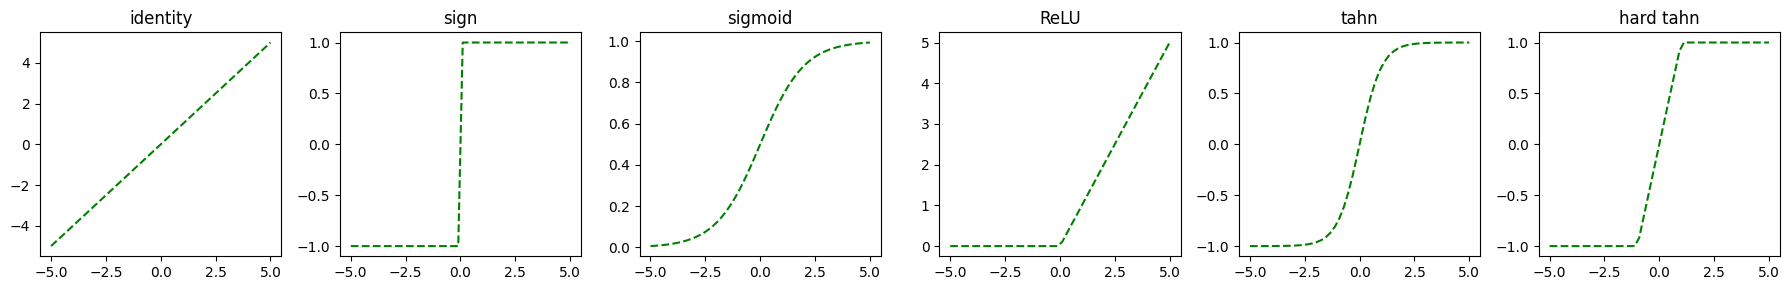

In [24]:
fig, ax = plt.subplots(figsize=(3*len(activation), 3), ncols=len(activation))
for i, (fun, f) in enumerate(activation.items()):
    ax[i].plot(data, f(data), 'g--')
    ax[i].set_title(fun)
plt.tight_layout()
plt.show()

### Una semplice rete neurale

Predire il tipo di cucina data la combinazione di ingredienti.

In [25]:
from sklearn.preprocessing import OneHotEncoder

In [60]:
db = pymongo.MongoClient()['cousine']
recipes = db['foodcom']
label_field = 'category'
data = []
labels = ['italian', 'indian', 'southern', 'mexican', 'chinese', 'greek', 'thai']

q = {'search_terms': {'$in': labels}}
for recipe in recipes.find(q):
    data.append({
        'ingredients': recipe['ingredients'],
        label_field: [x for x in recipe['search_terms'] if x in labels][0]
    })

In [61]:
train_data = data[:5000]
test_data = data[5000:6000]

In [62]:
vocabulary = list(pd.Series(document_frequency).sort_values(
    ascending=False).head(1000).keys().values)

In [63]:
enc_labels = OneHotEncoder(handle_unknown='ignore')

In [64]:
def get_data(data, vocabulary):
    features, labels = [], []
    for recipe in data:
        features.append([f for f in recipe['ingredients'] if f in vocabulary])
        labels.append([recipe[label_field]])
    return features, labels

In [65]:
train_docs, train_labels = get_data(train_data, vocabulary)
test_docs, test_labels = get_data(test_data, vocabulary)

In [66]:
train_labels[:2]

[['italian'], ['italian']]

In [67]:
X_train = np.zeros((len(train_docs), len(vocabulary)))
for i, doc in enumerate(train_docs):
    for ingredient in doc:
        X_train[i, vocabulary.index(ingredient)] = 1
y_train = enc_labels.fit_transform(np.array(train_labels)).toarray()

In [68]:
X_test = np.zeros((len(test_docs), len(vocabulary)))
for i, doc in enumerate(test_docs):
    for ingredient in doc:
        X_test[i, vocabulary.index(ingredient)] = 1
y_test = enc_labels.transform(np.array(test_labels)).toarray()

In [69]:
X_train

array([[0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], shape=(5000, 1000))

In [70]:
y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 1., ..., 0., 0., 0.]], shape=(5000, 7))

### Torch data loader

In [71]:
import torch
from torch.utils.data import TensorDataset, DataLoader

In [72]:
train_dataset = TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train))
train_dataloader = DataLoader(train_dataset, batch_size=10)

In [73]:
for (x, y) in train_dataloader:
    print(x.shape, y.shape)
    break

torch.Size([10, 1000]) torch.Size([10, 7])


In [74]:
test_dataset = TensorDataset(torch.Tensor(X_test), torch.Tensor(y_test))
test_dataloader = DataLoader(test_dataset, batch_size=10)

### The simple Net

In [75]:
import torch.nn as nn
import torch.nn.functional as F

In [76]:
class SimpleNet(nn.Module):

    def __init__(self, input_size, output_size):
        super(SimpleNet, self).__init__()
        self.fc = nn.Linear(input_size, output_size)

    def forward(self, x):
        x = F.softmax(self.fc(x), dim=0)
        return x

In [77]:
net = SimpleNet(X_train.shape[1], y_train.shape[1])

In [78]:
for (x, y) in train_dataloader:
    p = net(x)
    break

In [79]:
p.shape

torch.Size([10, 7])

In [80]:
p[0]

tensor([0.0989, 0.0934, 0.1082, 0.0964, 0.0972, 0.1130, 0.1034],
       grad_fn=<SelectBackward0>)

### Train

In [81]:
import time
import math

In [82]:
batches = [(doc, lab) for doc, lab in train_dataloader]
read_labels = [x.replace('x0_', '') for x in enc_labels.get_feature_names_out()]

In [83]:
def train(document_tensor, label_tensor, criterion, learning_rate):
    net.zero_grad()
    output = net(document_tensor)
    loss = criterion(output, label_tensor)
    loss.backward()

    for p in net.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)
    return output, loss.item()

In [84]:
n_iters = 60_000
print_every = 2000
plot_every = 200
criterion = nn.BCEWithLogitsLoss()
learning_rate = 0.1

current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

epochs = list(range(1, n_iters + 1))
for it in tqdm(epochs):
    document_tensor, label_tensor = batches[np.random.randint(0, len(batches) - 1)]
    output, loss = train(document_tensor, label_tensor, criterion, learning_rate)
    current_loss += loss

    if it % print_every == 0:
        preds = torch.argmax(output, dim=1)
        ground = torch.argmax(label_tensor, dim=1)
        for i, p in enumerate(preds[:3]):
            g = ground[i]
            print('{} ==> {}'.format(read_labels[p], read_labels[g]))

    if it % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

  0%|          | 0/60000 [00:00<?, ?it/s]

southern ==> southern
italian ==> italian
southern ==> indian
southern ==> mexican
southern ==> southern
chinese ==> thai
greek ==> greek
indian ==> mexican
mexican ==> italian
chinese ==> thai
indian ==> italian
southern ==> greek
indian ==> mexican
italian ==> southern
mexican ==> mexican
southern ==> southern
italian ==> italian
italian ==> italian
mexican ==> mexican
italian ==> southern
mexican ==> mexican
thai ==> southern
mexican ==> mexican
indian ==> mexican
thai ==> mexican
indian ==> indian
italian ==> mexican
southern ==> mexican
mexican ==> mexican
thai ==> thai
italian ==> italian
mexican ==> mexican
southern ==> mexican
chinese ==> southern
greek ==> italian
greek ==> italian
italian ==> italian
greek ==> italian
thai ==> italian
indian ==> italian
italian ==> italian
italian ==> italian
greek ==> mexican
southern ==> southern
indian ==> indian
thai ==> italian
southern ==> southern
chinese ==> chinese
mexican ==> mexican
mexican ==> mexican
italian ==> mexican
indian ==

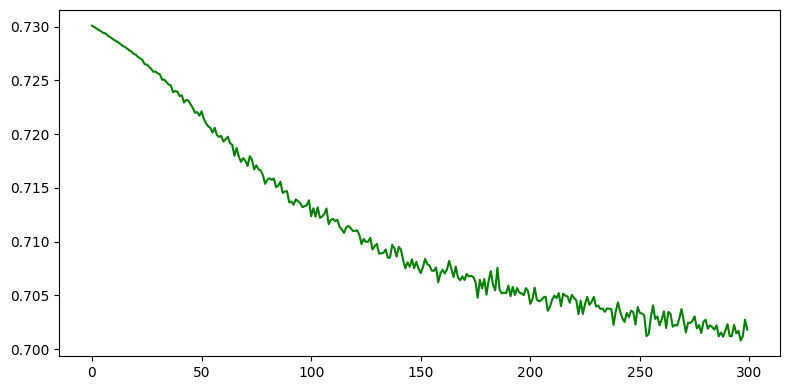

In [85]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(all_losses, 'g')
plt.tight_layout()
plt.show()

### Prediction on train

In [86]:
y_pred_train, y_true_train = [], []
for doc, lab in train_dataloader:
    output = net(doc)
    preds = torch.argmax(output, dim=1)
    ground = torch.argmax(lab, dim=1)
    for i, p in enumerate(preds):
        y_pred_train.append(p)
        g = ground[i]
        y_true_train.append(g)

In [87]:
print(mt.classification_report(y_true_train, y_pred_train))

              precision    recall  f1-score   support

           0       0.44      0.72      0.55       370
           1       0.31      0.64      0.41       324
           2       0.51      0.64      0.57       526
           3       0.77      0.48      0.59      1261
           4       0.77      0.52      0.62      1152
           5       0.61      0.49      0.54      1146
           6       0.27      0.71      0.39       221

    accuracy                           0.55      5000
   macro avg       0.53      0.60      0.53      5000
weighted avg       0.63      0.55      0.56      5000



### Prediction on test

In [88]:
y_pred, y_true = [], []
for doc, lab in test_dataloader:
    output = net(doc)
    preds = torch.argmax(output, dim=1)
    ground = torch.argmax(lab, dim=1)
    for i, p in enumerate(preds):
        y_pred.append(p)
        g = ground[i]
        y_true.append(g)

In [58]:
print(mt.classification_report(y_true, y_pred, zero_division=0))

              precision    recall  f1-score   support

           0       0.35      0.70      0.47        77
           1       0.26      0.49      0.34        72
           2       0.39      0.61      0.47        85
           3       0.81      0.47      0.60       265
           4       0.75      0.52      0.61       211
           5       0.05      0.26      0.09        19
           6       0.57      0.38      0.46       271

    accuracy                           0.48      1000
   macro avg       0.45      0.49      0.43      1000
weighted avg       0.61      0.48      0.51      1000



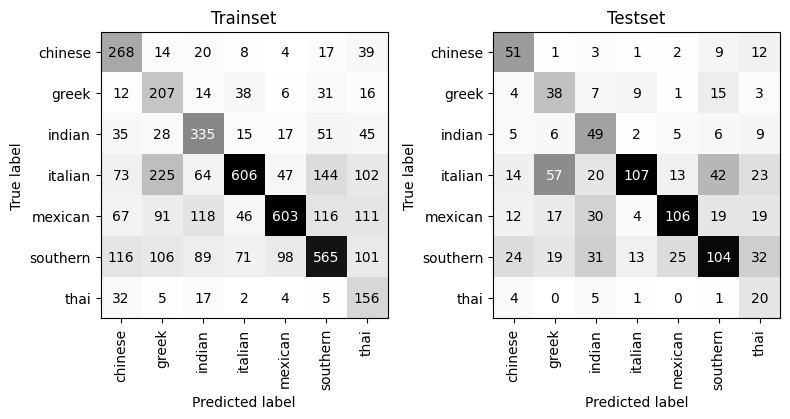

In [89]:
fig, ax = plt.subplots(figsize=(8, 6), ncols=2)
cmd_train = mt.ConfusionMatrixDisplay(confusion_matrix=mt.confusion_matrix(y_true_train, y_pred_train), 
                                      display_labels=read_labels)
cmd_test = mt.ConfusionMatrixDisplay(confusion_matrix=mt.confusion_matrix(y_true, y_pred), 
                                     display_labels=read_labels)
cmd_train.plot(ax=ax[0], cmap='Greys', colorbar=False, xticks_rotation='vertical')
cmd_test.plot(ax=ax[1], cmap='Greys', colorbar=False, xticks_rotation='vertical')
ax[0].set_title('Trainset')
ax[1].set_title('Testset')
plt.tight_layout()
plt.show()

## Alcune considerazioni sui parametri della rete.

In [90]:
print([x for x in net.named_parameters()])

[('fc.weight', Parameter containing:
tensor([[-1.0964e-01, -2.6931e-01, -4.4275e-01,  ..., -2.1630e-02,
         -2.6244e-03,  2.5610e-03],
        [-3.8753e-02, -2.3788e-01,  1.1332e+00,  ..., -8.5916e-05,
          5.5504e-03,  2.4858e-03],
        [ 1.1869e+00,  2.1029e-01, -4.4976e-01,  ..., -3.0088e-02,
         -6.5541e-03,  1.0172e-01],
        ...,
        [-3.5826e-01,  6.3850e-01, -3.2413e-01,  ..., -1.7901e-02,
          4.9231e-02, -2.7361e-02],
        [ 2.8774e-01,  1.4889e-01, -1.0919e+00,  ..., -6.3463e-03,
          2.5505e-03, -3.0546e-03],
        [-5.2923e-01, -2.1862e-01, -4.7149e-01,  ...,  1.5523e-02,
          3.6156e-03,  3.2467e-03]], requires_grad=True)), ('fc.bias', Parameter containing:
tensor([-0.0086, -0.0262,  0.0172,  0.0018,  0.0125,  0.0244, -0.0110],
       requires_grad=True))]


In [91]:
params = {name: param.detach().numpy() for name, param in net.named_parameters()}

In [92]:
params['fc.weight'].shape

(7, 1000)

Nota che in questo dataset abbiamo 7 classi e 1000 caratteristiche. Pertanto, possiamo associare un vettore di 6 valori a ciascuna caratteristica. Proviamo:

In [93]:
feature_vectors = pd.DataFrame(params['fc.weight'].T, index=vocabulary, columns=labels)
feature_vectors

,italian,indian,southern,mexican,chinese,greek,thai
salt,-0.109645,-0.038753,1.186860,-0.354072,-0.358256,0.287737,-0.529234
onion,-0.269314,-0.237881,0.210289,0.025597,0.638497,0.148887,-0.218618
olive oil,-0.442748,1.133159,-0.449760,1.393122,-0.324133,-1.091922,-0.471494
garlic cloves,0.063399,0.117800,0.147329,0.446771,-0.055125,-0.651909,0.323930
water,0.464773,-0.101849,0.373560,-0.196703,-0.093074,-0.138380,-0.294053
...,...,...,...,...,...,...,...
unsweetened cocoa,-0.037009,0.012722,0.013676,0.011184,0.009296,0.002590,-0.026150
unsweetened chocolate,0.000647,0.004279,-0.026260,0.015336,0.026875,-0.000232,-0.024571
bisquick,-0.021630,-0.000086,-0.030088,-0.038464,-0.017901,-0.006346,0.015523
condensed cream of chicken soup,-0.002624,0.005550,-0.006554,-0.019871,0.049231,0.002550,0.003616


Ora, proviamo a calcolare la similarità tra ingredienti utilizzando questi vettori.

In [94]:
from sklearn.metrics.pairwise import cosine_similarity

In [95]:
sigma = cosine_similarity(feature_vectors, feature_vectors)
S = pd.DataFrame(sigma, index=vocabulary, columns=vocabulary)

In [96]:
S.head()

,salt,onion,olive oil,garlic cloves,water,butter,sugar,garlic,eggs,tomatoes,...,white mushrooms,fish fillets,mexicorn,burrito-size flour tortillas,small shell pasta,unsweetened cocoa,unsweetened chocolate,bisquick,condensed cream of chicken soup,saffron thread
salt,1.000000,0.181382,-0.299863,-0.266289,0.598070,0.318870,0.154413,-0.262269,-0.116624,0.151702,...,-0.164122,0.765460,-0.114298,0.186918,-0.331248,0.370624,-0.492839,-0.278172,-0.252621,0.819063
onion,0.181382,1.000000,-0.259851,-0.290063,-0.074234,0.024862,-0.695428,-0.602504,-0.361231,0.466753,...,0.243584,0.151109,0.916199,-0.147325,-0.339789,0.535786,0.420609,-0.363254,0.654015,0.020301
olive oil,-0.299863,-0.259851,1.000000,0.621516,-0.271376,-0.257021,-0.475751,0.457577,0.056949,0.301229,...,-0.384091,-0.490537,-0.326896,-0.350703,0.751493,0.402447,0.378249,-0.188773,-0.307959,-0.079848
garlic cloves,-0.266289,-0.290063,0.621516,1.000000,-0.024151,-0.735331,-0.190487,0.829039,-0.490871,0.228966,...,0.010895,-0.380894,-0.174644,0.136948,0.747038,-0.100204,-0.137640,-0.248742,-0.264594,0.263587
water,0.598070,-0.074234,-0.271376,-0.024151,1.000000,-0.225523,0.308329,0.056663,-0.377138,-0.000165,...,-0.424261,0.223753,-0.280511,0.426175,-0.318542,-0.247369,-0.239102,-0.371731,-0.162471,0.510123


In [102]:
query = 'onions'
S.loc[query].sort_values(ascending=False).head(10)

onions                 1.000000
green cardamom pods    0.972789
gram flour             0.959758
garam masala powder    0.959225
black mustard seeds    0.941485
cumin seed             0.937880
plain yogurt           0.932732
ground turmeric        0.932362
cloves                 0.931517
cardamom               0.931344
Name: onions, dtype: float32

In [104]:
k_sigma = cosine_similarity(feature_vectors.T, feature_vectors.T)
K = pd.DataFrame(k_sigma, index=labels, columns=labels)

In [ ]:
K

In [106]:
K.loc['italian'].sort_values(ascending=False)

italian     1.000000
thai        0.257061
southern   -0.049443
greek      -0.125673
indian     -0.159022
chinese    -0.231015
mexican    -0.231176
Name: italian, dtype: float32